# Model development
Notebook overview:
- create benchmark model
- error metrics
- build model
- train
- evaluate
- deploy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nasdaq_train = pd.read_csv('../data/train_nasdaq.csv', index_col=0, header=None)
nasdaq_test = pd.read_csv('../data/test_nasdaq.csv', index_col=0, header=None)

In [3]:
eurusd_train = pd.read_csv('../data/train_eurusd.csv', index_col=0, header=None)
eurusd_test = pd.read_csv('../data/test_eurusd.csv', index_col=0, header=None)

# Benchmark
Because the benchmark model is very simple and needed only in this notebook, I will define it here. Simple Moving Average forecasting implementation:

In [4]:
class MA_regressor:
    def __init__(self, N=5):
        self.N = N
    
    def forward(self, price):
        return price[-self.N:].sum() / self.N
    
    def predict(self, data, steps=10):
        data = data[4].values
        predictions = [0] * steps
        for i in range(0,steps):
            predictions[i] = self.forward(np.append(data, predictions[:i]))
        return predictions

In [5]:
sample, steps = 30, 10
benchmark = MA_regressor(15)
y = benchmark.predict(nasdaq_train.iloc[:sample], steps)

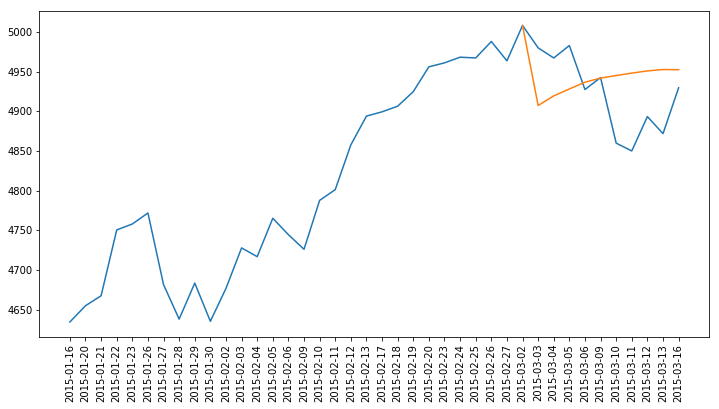

In [6]:
plt.figure(figsize=(12,6))
plt.xticks(rotation='vertical')
plt.plot(nasdaq_train.iloc[:sample+steps,3])
y_series = nasdaq_train.iloc[sample-1:sample+steps,3].copy()
y_series.iloc[1:] = y
plt.plot(y_series)

# Metrics
The sample prediction is not successfull at all, we need some metric to optimize it.

Because this is an regression problem, we need a loss function describing how far we are from the correct answer.
I propose an $MSE$ metric with a sum reduction:

\begin{equation}
MSE = \frac{1}{2} \left( y - \hat{y} \right)^2
\end{equation}

It will allow us to compute a gradient that moves towards a better solution.

In [7]:
def loss_fn(y_hat, y):
    mse = 0.0
    for a,b in zip(y_hat, y):
        mse += 0.5 * (a - b)**2
    return mse

## Optimizing our benchmark

In [8]:
target = nasdaq_train.iloc[sample:sample+steps,3].values
loss_fn(target, y)

18949.27026399682

In [9]:
def test(in_data, target, w=1):
    loss = [[], []]
    for i in range(2, 90):
        benchmark = MA_regressor(i)
        y = benchmark.predict(in_data, 10)
        loss[0].append(i)
        loss[1].append(loss_fn(target, y) / w)
    return np.array(loss)

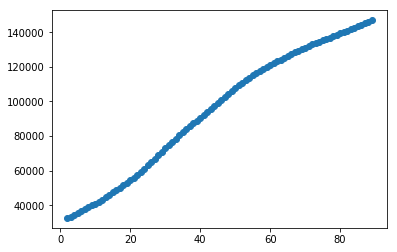

In [12]:
sample = 100
tests = 500

loss = test(nasdaq_train.iloc[:sample], nasdaq_train.iloc[sample:sample+steps,3].values, w=tests)
for offset in range(1,tests,2):
    loss[1] += test(nasdaq_train.iloc[offset:offset+sample],
                 nasdaq_train.iloc[offset+sample:offset+sample+steps,3].values, w=tests)[1]

plt.plot(*loss, 'o')

### Best benchmark model
It is clear that the lowest value of `N = 2` gives the best results over half of the NASDAQ train dataset.

Let's save it as our final benchmark.

In [13]:
benchmark = MA_regressor(N=2)

# LSTM model
Great, now that we know what the performance of our benchmark is, we can start developing a better solution.
Inside `model/model.py` I have created 2 similar LSTM Regression classes:
- LSTMRegeressor - which uses convolution to normalize the data,
- LSTMBatchRegressor - which normalizes the data with trainable 1-D Batch Normalization layer.

I will train both of them and compare the results.

## Data Loader
Before we start we need to create a data loader for our problem.
The best approach is to use a sliding window over the dataset.

In [ ]:
import torch
import torch.utils.data

class SlidingWindowDataset(torch.utils.data.IterableDataset):
    def __init__(self, data, window_size):
        super().__init__()
        self.timeseries = data
        self.window = window_size
        self.length = len(self.timeseries)
        
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None: # single-process data loading, return the full iterator
            start = 0
            end = self.length
        else: # split if inside a worker process
            per_worker = int(math.ceil(self.length / float(worker_info.num_workers)))
            worker_id = worker_info.id
            start = worker_id * per_worker
            end = min(start + per_worker, self.length)
        return iter(range(start, end))

## Uploading data
We need to store our input files on S3 server.

In [ ]:
import os.path
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/stock_forecasting'

role = sagemaker.get_execution_role()

In [ ]:
data_dir = '../data/'
for file in ['train_nasdaq.csv', 'train_eurusd.csv', 'test_nasdaq.csv', 'test_eurusd.csv']:
    sagemaker_session.upload_data(path=os.path.join(data_dir, file), bucket=bucket, key_prefix=prefix)